# To-do

- toggle display 
- options for video filename

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animate
from IPython.display import HTML, display
import subprocess
from glob import glob
import pandas as pd

import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

# Test some parameters to see what you like

In [2]:
def test_parameters(input_image, lesion_mask, lesion_color='autumn', lesion_transparency=0.5, figure_size=(3.5, 4), directions=['x', 'y', 'z']):
    
    """
    Display region of interest (ROI) overlays on brain images for multiple directions. You can use this to find your optimal lesion color, lesion transparecy, and figure size.
    

    Parameters:
    - input_image (str): Path to the input brain image file.
    - lesion_mask (str): Path to the lesion mask file.
    - lesion_color (str, optional): Color of the lesion mask overlay. Uses cmap arg, so checkout matplotlib.colormaps for options. Defaults to 'autumn'.
    - lesion_transparency (float, optional): Transparency level of the lesion mask overlay (0-1). Defaults to 0.5.
    - figure_size (tuple, optional): Size of the figure (width, height) in inches. Defaults to (3.5, 4).
    - directions (list of str, optional): List of directions ('x', 'y', 'z') for displaying the overlays. Defaults to ['x', 'y', 'z'].


    Notes:
    - Uses Nilearn's plot_roi function to overlay lesion masks on input images.
    """
        
    fig, axes = plt.subplots(1, len(directions), figsize=(figure_size[0] * len(directions), figure_size[1]))
    
    for i, direction in enumerate(directions):
        plotting.plot_roi(lesion_mask, bg_img=input_image, display_mode=direction,
                          figure=fig, cmap=lesion_color, alpha=lesion_transparency,
                          cut_coords=[0], annotate=False, draw_cross=False, axes=axes[i])

    plt.show()


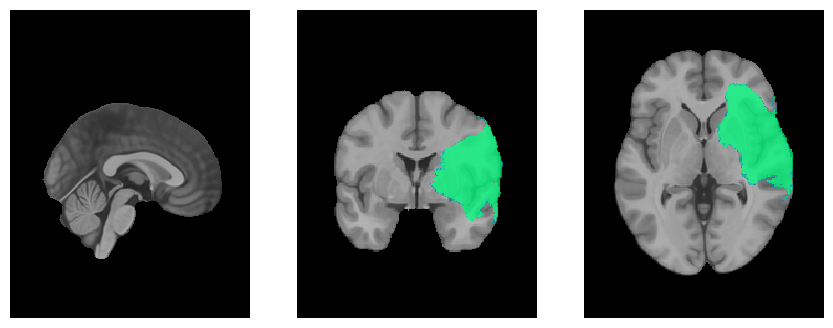

In [115]:
test_parameters(input_image='0_registration_targets/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii.gz', 
                lesion_mask='LF/ANTS/sub-MGH185_space-MNI_lesion.nii.gz',
                lesion_color='winter', lesion_transparency=0.75,
                figure_size=(3.5, 4),
                directions=['x','y', 'z'])

# Create a gif or video

In [50]:
def create_gif(bg_image, lesion_mask=None, output_dir=None, title=None, output_filename=None, **kwargs):
    
    """
    .
    .
    .
    
    Create a GIF or video with an overlay of a lesion mask on a brain image.

    Required Parameters:
    - bg_image (str): Path to the background brain image file.
    - lesion_mask (str): Path to the lesion mask file.

    Optional Parameters:
    - output_dir (str, optional): Directory where the output GIF or video will be saved. Defaults to 'Lesion_Visualization'.
    - title (str, optional): Title of the GIF or video. If none provided, uses lesion mask basename.
    - output_filename (str, optional): Name of the GIF or video file. If none provided, uses lesion mask basename.
    - output_type (str, optional): 'GIF' or 'Video'. Defaults to 'GIF'.
    -orientation: NEUROLOGICAL or RADIOLOGICAL
    
    Optional Parameters - Image Style:
    - reverse (bool, optional): Whether to reverse the direction of the slices. Defaults to False.
    - lesion_color (str, optional): Color of the lesion mask overlay. Defaults to 'autumn'.
    - lesion_transparency (float, optional): Transparency level of the lesion mask overlay (0-1). Defaults to 0.5.
    - figure_size (tuple, optional): Size of the figure (width, height) in inches. Defaults to (3.5, 4).
    - direction (str, optional): Direction of the slices: 'axial', 'coronal', or 'sagittal'. Also accepts 'z', 'y', 'x'. Defaults to 'axial'.
    - interval (int, optional): Interval between frames in milliseconds. Defaults to 60.
    - repeat_delay (int, optional): Delay before repeating the animation in milliseconds. Defaults to 500.

    Example usage:
    create_gif_with_lesion_mask('0_registration_targets/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii.gz',
                                'LF/ANTS/sub-MGH185_space-MNI_lesion.nii.gz',
                                'Lesion on MNI', **kwargs)
    """
        
    
        
    if output_dir is None:
        output_dir = os.getcwd() 
    else:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir) 
    
    if title is None and lesion_mask is None:
        title = os.path.basename(bg_image).split('.')[0]
    else:
        title = os.path.basename(lesion_mask).split('.')[0]
    
    if output_filename is None:
        output_filename=title

       
    visualize=kwargs.get('visualize', False)
    orientation=kwargs.get('orientation', 'NEUROLOGICAL')
    interval = kwargs.get('interval', 60)
    repeat_delay = kwargs.get('repeat_delay', 500)
    output_type = kwargs.get('output_type', 'GIF')
    reverse = kwargs.get('reverse', False)
    lesion_color = kwargs.get('lesion_color', 'autumn')
    lesion_transparency = kwargs.get('lesion_transparency', 0.5)
    figure_size = kwargs.get('figure_size', (3.5, 4))
    direction = kwargs.get('direction', 'axial')

    
    images_roi = []
    input_path = nib.load(bg_image)
    input_image_data = input_path.get_fdata()
    
    if lesion_mask:
        mask_path = nib.load(lesion_mask)
        lesion_mask_data = mask_path.get_fdata()
    else:
        lesion_mask_data = np.zeros(input_image_data.shape)

    fig = plt.figure(figsize=figure_size)

    
    if orientation not in ['NEUROLOGICAL', 'RADIOLOGICAL']:
        raise ValueError("Invalid orientation. Please choose either 'NEUROLOGICAL' or 'RADIOLOGICAL'.")
        
    img_orientation=subprocess.check_output(f'fslorient {bg_image}', shell=True).decode('utf-8').strip()

        
    if img_orientation == 'NEUROLOGICAL':
        left_label = 'L'
        right_label = 'R'
    elif img_orientation == 'RADIOLOGICAL':
        left_label = 'R'
        right_label = 'L'
    else:
        raise ValueError("Invalid orientation: {}".format(orientation))
    
    flip=False
    if orientation != img_orientation:
        flip = True
        left_label, right_label = right_label, left_label

    if direction == 'axial' or direction == 'z':
        slice_range = range(input_image_data.shape[2])
    elif direction == 'coronal' or direction == 'y':
        slice_range = range(input_image_data.shape[1])
    elif direction == 'sagittal' or direction == 'x':
        slice_range = range(input_image_data.shape[0])
        left_label=None
        right_label=None
    else:
        raise ValueError("Invalid orientation. Valid options are 'axial' or 'z', 'coronal' or 'y', and 'sagittal' or 'x'.")
        
    if reverse:
        slice_range = reversed(slice_range)
    
        


    for i in slice_range:
        if direction == 'axial' or direction == 'z':
            rotated_image_data = np.transpose(input_image_data[:, :, i])[::1, :]
            transposed_lesion_mask = np.transpose(lesion_mask_data[:, :, i])[::1, :]
        elif direction == 'coronal' or direction == 'y':
            rotated_image_data = np.transpose(input_image_data[:, i, :])[::1, :]
            transposed_lesion_mask = np.transpose(lesion_mask_data[:, i, :])[::1, :]
        elif direction == 'sagittal' or direction == 'x':
            rotated_image_data = np.transpose(input_image_data[i, :, :])[::1, :]
            transposed_lesion_mask = np.transpose(lesion_mask_data[i, :, :])[::1, :]
    
    
        if flip: #not working
            rotated_image_data = np.fliplr(rotated_image_data)
            transposed_lesion_mask = np.fliplr(transposed_lesion_mask)

            
        
        masked_image = np.ma.masked_where(transposed_lesion_mask == 0, rotated_image_data)
        
        im = plt.imshow(rotated_image_data, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data.shape[1], 0, input_image_data.shape[0]])
        im_masked = plt.imshow(masked_image, animated=True, cmap=lesion_color, alpha=lesion_transparency, aspect='auto', origin='lower', extent=[0, input_image_data.shape[1], 0, input_image_data.shape[0]])
        
      
        images_roi.append([im, im_masked])
        
        
        if left_label is not None and right_label is not None:
            plt.text(0.05, 0.5, left_label, transform=fig.transFigure, fontsize=12, va='center', ha='center')
            plt.text(0.95, 0.5, right_label, transform=fig.transFigure, fontsize=12, va='center', ha='center')

        
    ani = animate.ArtistAnimation(fig, images_roi, interval=60, blit=True, repeat_delay=500)
    
    plt.title(title, fontsize=20)
    plt.axis('off')
    
    if output_type == 'GIF':
        ani.save(f'{output_dir}/{output_filename}.gif', writer='pillow')
        plt.close()
        if visualize:
            display(HTML(f'<img src="{output_dir}/{output_filename}.gif">'))
    elif output_type == 'Video':
        ani.save(f'{output_dir}/{output_filename}.mp4', writer='ffmpeg', fps=10)  # Save as MP4 video
        plt.close()
        if visualize:
            display(HTML(f'<video width="400" controls><source src="{output_dir}/{output_filename}.mp4" type="video/mp4"></video>'))
    else:
        raise ValueError("Invalid output type. Valid options are 'GIF' and 'Video'")
        


In [51]:
create_gif('ANTS_Quick_s/sub-MGH185_space-MNI.nii.gz', 'ANTS_Quick_s/sub-MGH185_space-MNI_lesion.nii.gz', 
           visualize=True, output_filename='no_ori')

In [30]:
bg_image='ANTS_Quick_s/sub-MGH185_space-MNI.nii.gz'
subprocess.check_output(f'fslorient {bg_image}', shell=True).decode('utf-8').strip()

'NEUROLOGICAL'

In [49]:
create_gif_with_lesion_mask('0_registration_targets/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii.gz', 
                            'LF/ANTS/sub-MGH185_space-MNI_lesion.nii.gz', 
                            title='Lesion on MNI')
                           #**user_selections)

# Example: creating many gifs or videos using a csv

In [69]:
lesion_files = glob('/lab-share/Neuro-Cohen-e2/Public/lesions/BCH_Perinatal_Stroke_BIDS/derivatives/lesions/sub-BCH*/*MNI*desc-lesion*.nii.gz')

In [70]:
len(lesion_files)

41

In [71]:
#subject=os.path.splitext(os.path.basename(input_image))[0].split('_')[0]
df = pd.DataFrame({'lesion_file': lesion_files})
df['registration_target'] = '/lab-share/Neuro-Cohen-e2/Public/lesions/BCH_Perinatal_Stroke_BIDS/bids_lesion_code/icbm152_t1_tal_nlin_asym_09c_masked.nii.gz'

df['filename'] = df['lesion_file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0].split('_')[0]) + '_MNI-space'
df['title']=df['lesion_file'].apply(lambda x: os.path.splitext(os.path.basename(x))[0].split('_')[0])

df[:2]

,lesion_file,registration_target,filename,title
0,/lab-share/Neuro-Cohen-e2/Public/lesions/BCH_P...,/lab-share/Neuro-Cohen-e2/Public/lesions/BCH_P...,sub-BCH012_MNI-space,sub-BCH012
1,/lab-share/Neuro-Cohen-e2/Public/lesions/BCH_P...,/lab-share/Neuro-Cohen-e2/Public/lesions/BCH_P...,sub-BCH090_MNI-space,sub-BCH090


In [74]:
df[:2].apply(lambda row: 
         create_gif(row['registration_target'], row['lesion_file'], output_dir='Lesion_GIFs',
                                     title=row['title'], output_filename=row['filename']), axis=1)

0    None
1    None
dtype: object

# Multiple Directions WIP

In [ ]:


def apply_column_mapping(column_mapping, df):
    # Rename columns using the provided mapping dictionary
    df.rename(columns=column_mapping, inplace=True)
    return df


def create_gif_with_lesion_mask(bg_images, lesion_masks, output_dir='Lesion_Visualization', title=None, output_filename=None, **kwargs):
    
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    if title is None:
        title = os.path.basename(lesion_mask).split('.')[0]

    interval = kwargs.get('interval', 60)
    repeat_delay = kwargs.get('repeat_delay', 500)
    output_type = kwargs.get('output_type', 'GIF')
    reverse = kwargs.get('reverse', False)
    lesion_color = kwargs.get('lesion_color', 'autumn')
    lesion_transparency = kwargs.get('lesion_transparency', 0.5)
    figure_size = kwargs.get('figure_size', (3.5, 4))
    direction = kwargs.get('direction', 'axial')
    
    
    
    for index, row in df.iterrows():
        input_image_1 = row['input_image_1']
        input_image_2 = row['input_image_2']
        lesion_mask_1 = row['lesion_mask_1']
        lesion_mask_2 = row['lesion_mask_2']
        title = row['title']
        
        # Load image and mask data for the first brain
        input_path_1 = nib.load(input_image_1)
        input_image_data_1 = input_path_1.get_fdata()
        
        mask_path_1 = nib.load(lesion_mask_1)
        lesion_mask_data_1 = mask_path_1.get_fdata()
        
        # Load image and mask data for the second brain
        input_path_2 = nib.load(input_image_2)
        input_image_data_2 = input_path_2.get_fdata()
        
        mask_path_2 = nib.load(lesion_mask_2)
        lesion_mask_data_2 = mask_path_2.get_fdata()
        
        fig, axs = plt.subplots(1, 2, figsize=(7, 4))
        
        for ax, title_text in zip(axs, [left_title, right_title]):
            ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title_text, fontsize=16)

        images = []
    
        for i in range(input_image_data_1.shape[2]):
            rotated_image_data_1 = np.transpose(input_image_data_1[:, :, i])[::1, :]
            rotated_image_data_2 = np.transpose(input_image_data_2[:, :, i])[::1, :]

            transposed_lesion_mask_1 = np.transpose(lesion_mask_data_1[:, :, i])[::1, :]
            transposed_lesion_mask_2 = np.transpose(lesion_mask_data_2[:, :, i])[::1, :]

            masked_image_1 = np.ma.masked_where(transposed_lesion_mask_1 == 0, rotated_image_data_1)
            masked_image_2 = np.ma.masked_where(transposed_lesion_mask_2 == 0, rotated_image_data_2)

            im1 = axs[0].imshow(rotated_image_data_1, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data_1.shape[1], 0, input_image_data_1.shape[0]])
            im1_masked = axs[0].imshow(masked_image_1, animated=True, cmap='autumn', alpha=0.5, aspect='auto', origin='lower', extent=[0, input_image_data_1.shape[1], 0, input_image_data_1.shape[0]])

            im2 = axs[1].imshow(rotated_image_data_2, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data_2.shape[1], 0, input_image_data_2.shape[0]])
            im2_masked = axs[1].imshow(masked_image_2, animated=True, cmap='autumn', alpha=0.5, aspect='auto', origin='lower', extent=[0, input_image_data_2.shape[1], 0, input_image_data_2.shape[0]])

            images.append([im1, im1_masked, im2, im2_masked])

        ani = animate.ArtistAnimation(fig, images, interval=60, blit=True, repeat_delay=500)
    
        plt.title(title, fontsize=20)
    # plt.axis('off')
    
        ani.save(os.path.join(output_dir, f'{title}.mp4'), writer='ffmpeg', fps=10)
    
    
    #plt.show()
    
        plt.close()
    display(HTML(f'<video width="400" controls><source src="{title}.mp4" type="video/mp4"></video>'))

    plt.close()

In [7]:
#def create_gif_with_lesion_mask(input_image, lesion_mask, title=None, reverse=True, lesion_color='autumn', lesion_transparency=0.5, figure_size=(3.5, 4), direction='z'):

def create_gif_with_lesion_mask(bg_image, lesion_mask, title=None, output_type='GIF', **kwargs):
    
    """
    Create a GIF with an overlay of a lesion mask on a brain image.

    Parameters:
    - bg_image (str): Path to the background brain image file.
    - lesion_mask (str): Path to the lesion mask file.
    - title (str, optional): Title of the GIF. Defaults to None.
    - output_type (str, optional): 'GIF' or 'Video'. Defaults to 'GIF'.
    - reverse (bool, optional): Whether to reverse the direction of the slices. Defaults to True.
    - lesion_color (str, optional): Color of the lesion mask overlay. Defaults to 'autumn'.
    - lesion_transparency (float, optional): Transparency level of the lesion mask overlay (0-1). Defaults to 0.5.
    - figure_size (tuple, optional): Size of the figure (width, height) in inches. Defaults to (3.5, 4).
    - direction (str, optional): Direction of the slices: 'axial', 'coronal', or 'sagittal'. Also accepts 'z', 'y', 'x'. Defaults to 'axial'.
    
    Example usage:
    create_gif_with_lesion_mask('0_registration_targets/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii.gz', 
                            'LF/ANTS/sub-MGH185_space-MNI_lesion.nii.gz', 
                            'Lesion on MNI',
                           **user_selections)
    """
        
    # Define default values for parameters
    defaults = {
        'reverse': True,
        'lesion_color': 'autumn',
        'lesion_transparency': 0.5,
        'figure_size': [3.5, 4],
        'direction': 'z'
    }

    # Update defaults with user selections
    user_selections = {**defaults, **kwargs}

    # Extract parameters from the user selections
    reverse = user_selections['reverse']
    lesion_color = user_selections['lesion_color']
    lesion_transparency = user_selections['lesion_transparency']
    figure_size = user_selections['figure_size']
    direction = user_selections['direction']

  
    images_roi = []
    
    subject=os.path.splitext(os.path.basename(bg_image))[0].split('_')[0]
    
    if title is None:
        title = os.path.splitext(os.path.basename(bg_image))[0]
    
    
    input_path = nib.load(bg_image)
    input_image_data = input_path.get_fdata()
    
    mask_path = nib.load(lesion_mask)
    lesion_mask_data = mask_path.get_fdata()

    fig, axs = plt.subplots(1, len(direction), figsize=(figure_size[0]*len(direction), figure_size[1]))
    
    orientation=subprocess.check_output(f'fslorient {bg_image}', shell=True).decode('utf-8').strip()
    if orientation == 'NEUROLOGICAL':
        left_label = 'L'
        right_label = 'R'
    elif orientation == 'RADIOLOGICAL':
        left_label = 'R'
        right_label = 'L'
    else:
        raise ValueError("Invalid orientation: {}".format(orientation))

    if direction == 'axial' or direction == 'z':
        slice_range = range(input_image_data.shape[2])
    elif direction == 'coronal' or direction == 'y':
        slice_range = range(input_image_data.shape[1])
    elif direction == 'sagittal' or direction == 'x':
        slice_range = range(input_image_data.shape[0])
        left_label=None
        right_label=None
    else:
        raise ValueError("Invalid orientation. Valid options are 'axial' or 'z', 'coronal' or 'y', and 'sagittal' or 'x'.")
        
    if reverse:
        slice_range = reversed(slice_range)

    for i,direction in enumerate(direction):
        
        for i in slice_range:
            if direction == 'axial' or direction == 'z':
                rotated_image_data_ax = np.transpose(input_image_data[:, :, i])[::1, :]
                transposed_lesion_mask_ax = np.transpose(lesion_mask_data[:, :, i])[::1, :]
                
            elif direction == 'coronal' or direction == 'y':
                rotated_image_data = np.transpose(input_image_data[:, i, :])[::1, :]
                transposed_lesion_mask = np.transpose(lesion_mask_data[:, i, :])[::1, :]
            elif direction == 'sagittal' or direction == 'x':
                rotated_image_data = np.transpose(input_image_data[i, :, :])[::1, :]
                transposed_lesion_mask = np.transpose(lesion_mask_data[i, :, :])[::1, :]

    # Set up loop for L/R flexibility
    #rotated_image_data = np.fliplr(np.transpose(input_image_data[i, :, :])[::1, :])
    #transposed_lesion_mask = np.fliplr(np.transpose(lesion_mask_data[i, :, :])[::1, :])
            
        
        masked_image = np.ma.masked_where(transposed_lesion_mask == 0, rotated_image_data)
        
        im = axs[0].imshow(rotated_image_data, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data.shape[1], 0, input_image_data.shape[0]])
        im_masked = axs[0].imshow(masked_image, animated=True, cmap=lesion_color, alpha=lesion_transparency, aspect='auto', origin='lower', extent=[0, input_image_data.shape[1], 0, input_image_data.shape[0]])
        
        if len(direction) == 1:
        im = axs.imshow(rotated_image_data, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data.shape[1], 0, input_image_data.shape[0]])
        im_masked = axs.imshow(masked_image, animated=True, cmap=lesion_color, alpha=lesion_transparency, aspect='auto', origin='lower', extent=[0, input_image_data.shape[1], 0, input_image_data.shape[0]])
        
        images_roi.append([im, im_masked])
        
        
        if left_label is not None and right_label is not None:
            plt.text(0.05, 0.5, left_label, transform=fig.transFigure, fontsize=12, va='center', ha='center')
            plt.text(0.95, 0.5, right_label, transform=fig.transFigure, fontsize=12, va='center', ha='center')

        
    ani = animate.ArtistAnimation(fig, images_roi, interval=60, blit=True, repeat_delay=500)
    
    plt.title(title, fontsize=20)
    plt.axis('off')
    
    if output_type == 'GIF':
        ani.save(f'{subject}_masked.gif', writer='pillow')
        plt.close()
        display(HTML(f'<img src="{subject}_masked.gif">'))
    elif output_type == 'Video':
        ani.save(f'{subject}_masked.mp4', writer='ffmpeg', fps=10)  # Save as MP4 video
        plt.close()
        display(HTML(f'<video width="400" controls><source src="{subject}_masked.mp4" type="video/mp4"></video>'))
    else:
        raise ValueError("Invalid output type. Valid options are 'GIF' and 'Video'")
        


TypeError: 'AxesSubplot' object is not subscriptable

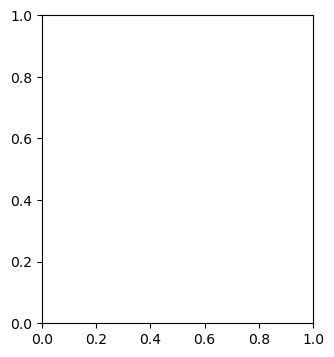

In [9]:
create_gif_with_lesion_mask(input_image='0_registration_targets/mni_icbm152_t1_tal_nlin_asym_09c_brain.nii.gz', 
                lesion_mask='LF/ANTS/sub-MGH185_space-MNI_lesion.nii.gz'
                )

In [ ]:


def apply_column_mapping(column_mapping, df):
    # Rename columns using the provided mapping dictionary
    df.rename(columns=column_mapping, inplace=True)
    return df


    
def create_video_with_lesion_mask_from_csv(csv_file, output_dir, 
                                           left_title='Source', right_title='Registered'):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    df = pd.read_csv(csv_file)
    df = apply_column_mapping(column_mapping, df)
    
    for index, row in df.iterrows():
        input_image_1 = row['input_image_1']
        input_image_2 = row['input_image_2']
        lesion_mask_1 = row['lesion_mask_1']
        lesion_mask_2 = row['lesion_mask_2']
        title = row['title']
        
        # Load image and mask data for the first brain
        input_path_1 = nib.load(input_image_1)
        input_image_data_1 = input_path_1.get_fdata()
        
        mask_path_1 = nib.load(lesion_mask_1)
        lesion_mask_data_1 = mask_path_1.get_fdata()
        
        # Load image and mask data for the second brain
        input_path_2 = nib.load(input_image_2)
        input_image_data_2 = input_path_2.get_fdata()
        
        mask_path_2 = nib.load(lesion_mask_2)
        lesion_mask_data_2 = mask_path_2.get_fdata()
        
        fig, axs = plt.subplots(1, 2, figsize=(7, 4))
        
        for ax, title_text in zip(axs, [left_title, right_title]):
            ax.axis('off')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(title_text, fontsize=16)

        images = []
    
        for i in range(input_image_data_1.shape[2]):
            rotated_image_data_1 = np.transpose(input_image_data_1[:, :, i])[::1, :]
            rotated_image_data_2 = np.transpose(input_image_data_2[:, :, i])[::1, :]

            transposed_lesion_mask_1 = np.transpose(lesion_mask_data_1[:, :, i])[::1, :]
            transposed_lesion_mask_2 = np.transpose(lesion_mask_data_2[:, :, i])[::1, :]

            masked_image_1 = np.ma.masked_where(transposed_lesion_mask_1 == 0, rotated_image_data_1)
            masked_image_2 = np.ma.masked_where(transposed_lesion_mask_2 == 0, rotated_image_data_2)

            im1 = axs[0].imshow(rotated_image_data_1, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data_1.shape[1], 0, input_image_data_1.shape[0]])
            im1_masked = axs[0].imshow(masked_image_1, animated=True, cmap='autumn', alpha=0.5, aspect='auto', origin='lower', extent=[0, input_image_data_1.shape[1], 0, input_image_data_1.shape[0]])

            im2 = axs[1].imshow(rotated_image_data_2, animated=True, cmap='gray', aspect='auto', origin='lower', extent=[0, input_image_data_2.shape[1], 0, input_image_data_2.shape[0]])
            im2_masked = axs[1].imshow(masked_image_2, animated=True, cmap='autumn', alpha=0.5, aspect='auto', origin='lower', extent=[0, input_image_data_2.shape[1], 0, input_image_data_2.shape[0]])

            images.append([im1, im1_masked, im2, im2_masked])

        ani = animate.ArtistAnimation(fig, images, interval=60, blit=True, repeat_delay=500)
    
        plt.title(title, fontsize=20)
    # plt.axis('off')
    
        ani.save(os.path.join(output_dir, f'{title}.mp4'), writer='ffmpeg', fps=10)
    
    
    #plt.show()
    
        plt.close()
    display(HTML(f'<video width="400" controls><source src="{title}.mp4" type="video/mp4"></video>'))

    plt.close()